# Equation of State curve - basic QE

Running an EOS without all the fancy features in the `aiida-quantumespresso` plugin.

In [1]:
from pathlib import Path

from aiida import orm, engine, load_profile

load_profile()

Profile<uuid='636ce0ecaed848c18631033f4daed624' name='test'>

## Importing a structure

In [2]:
from ase import io as ase_io

structure = orm.StructureData(ase=ase_io.read('files/Al.cif'))

## Relaxing the geometry

In [3]:
resources = {
    'num_machines': 1,
    'num_mpiprocs_per_machine': 1
}

relax_params = {
    'CONTROL': {
        'calculation': 'vc-relax',
        'pseudo_dir': Path('files').absolute().as_posix(),
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

In [4]:
from aiida_qe_basic.pw import PwCalculation

builder = PwCalculation.get_builder()

builder.code = orm.load_code('pw@localhost')
builder.structure = orm.StructureData(ase=ase_io.read('files/Al.cif'))
builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
builder.parameters = orm.Dict(relax_params)
builder.metadata.options.resources = resources

In [5]:
results = engine.run(builder)
relaxed_structure = results['structure']
relaxed_structure

<StructureData: uuid: c56d7c1f-6d24-49eb-a8d6-e188d4c3a73f (pk: 24)>

## Calc function to rescale structures

The `calcfunction` below takes an input structure and rescales it to different volumes.

In [6]:
from aiida_qe_basic.pw import PwCalculation

@engine.calcfunction
def rescale_list(structure: orm.StructureData, factor_list: orm.List):

    scaled_structure_dict = {}

    for index, scaling_factor in enumerate(factor_list.get_list()):

        ase_structure = structure.get_ase()

        new_cell = ase_structure.get_cell() * scaling_factor
        ase_structure.set_cell(new_cell, scale_atoms=True)

        scaled_structure_dict[f'structure_{index}'] = orm.StructureData(ase=ase_structure)

    return scaled_structure_dict

Typically, you'd just run it by calling the function as you would a regular Python function:

In [7]:
rescaled_structures = rescale_list(relaxed_structure, orm.List(list=[0.9, 0.95, 1.0, 1.05, 1.1]))

In [8]:
rescaled_structures

{'structure_0': <StructureData: uuid: a0c7f87f-86a3-46cf-93c1-fb514f143599 (pk: 28)>,
 'structure_1': <StructureData: uuid: 59f8e747-eff6-4eec-ba24-e823b8747b45 (pk: 29)>,
 'structure_2': <StructureData: uuid: 8be3e1df-4d41-42bd-ba8c-6fed38ec7b77 (pk: 30)>,
 'structure_3': <StructureData: uuid: e1b2c16b-a98b-485f-9aa6-52985737f02f (pk: 31)>,
 'structure_4': <StructureData: uuid: e7652004-c65d-46c1-ab57-f4dc050649dd (pk: 32)>}

## EOS: Work function version

In [9]:
scf_inputs = {
    'CONTROL': {
        'calculation': 'scf',
        'pseudo_dir': Path('files').absolute().as_posix(),
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

In [10]:
@engine.workfunction
def run_eos_wf(code: orm.Code, structure: orm.StructureData, scale_factors: orm.List):
    """Run an equation of state of a bulk crystal structure for the given element."""

    properties = {}

    for label, rescaled_structure in rescale_list(structure, scale_factors).items():

        builder = PwCalculation.get_builder()
        builder.code = code
        builder.structure = rescaled_structure
        builder.parameters = orm.Dict(scf_inputs)
        builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
        builder.metadata.options.resources = resources

        results = engine.run(builder)
        properties[label] = results['properties']

    return properties

In [11]:
results = run_eos_wf(
    code=orm.load_code('pw@localhost'),
    structure=relaxed_structure,
    scale_factors=[0.9, 0.95, 1.0, 1.05, 1.1]
)

In [13]:
results

{'structure_0': <Dict: uuid: 9b7a124f-1800-44bd-a300-67476f4a1a99 (pk: 47)>,
 'structure_1': <Dict: uuid: 535732b4-5d6e-492c-a75c-be06e7a9e054 (pk: 54)>,
 'structure_2': <Dict: uuid: 883b00a3-f5cc-4520-a2b9-d5fa5e347d6d (pk: 61)>,
 'structure_3': <Dict: uuid: e751d5c8-becd-4191-9c9c-b5f55c88573d (pk: 68)>,
 'structure_4': <Dict: uuid: 8ccb6a17-685e-4b13-9b55-a80e6c56908f (pk: 75)>}

In [14]:
volumes = []
energies = []

for result in results.values():
    volumes.append(result['volume'])
    energies.append(result['energy'])

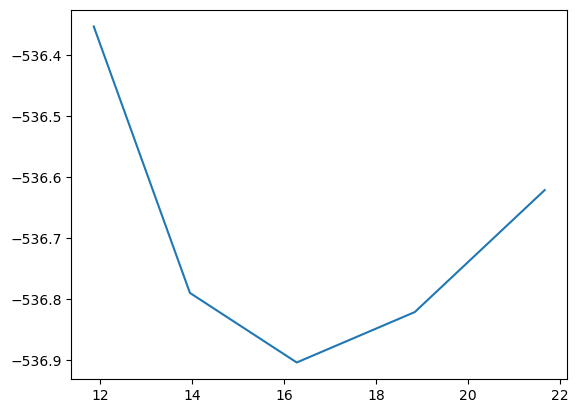

In [15]:
import matplotlib.pyplot as plt

plt.plot(volumes, energies)

## Work chain version

In [16]:
@engine.calcfunction
def create_eos_dictionary(**kwargs) -> orm.Dict:
    eos = {
        label: (result['volume'], result['energy'])
        for label, result in kwargs.items()
    }
    return orm.Dict(eos)

In [17]:
create_eos_dictionary(**results).get_dict()

{'structure_0': [11.863200733459, -536.3535586307],
 'structure_1': [13.952279463442, -536.79015879477],
 'structure_2': [16.273252034923, -536.90415317779],
 'structure_3': [18.838323386928, -536.82149044905],
 'structure_4': [21.659698458483, -536.62164959218]}

In [18]:
class EquationOfState(engine.WorkChain):
    """WorkChain to compute Equation of State using Quantum ESPRESSO."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input("code", valid_type=orm.Code)
        spec.input("structure", valid_type=orm.StructureData)
        spec.input("scale_factors", valid_type=orm.List)

        spec.outline(
            cls.run_eos,
            cls.results,
        )
        spec.output("eos_dict", valid_type=orm.Dict)

    def run_eos(self):

        calcjob_dict = {}

        for label, rescaled_structure in rescale_list(self.inputs.structure, self.inputs.scale_factors).items():

            builder = PwCalculation.get_builder()
            builder.code = self.inputs.code
            builder.structure = rescaled_structure
            builder.parameters = orm.Dict(scf_inputs)
            builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
            builder.metadata.options.resources = resources

            calcjob_dict[label] = self.submit(builder)

        self.ctx.labels = list(calcjob_dict.keys())

        return calcjob_dict

    def results(self):

        self.report(self.ctx)

        eos_results = {
            label: self.ctx[label].outputs['properties'] for label in self.ctx.labels
        }
        eos_dict = create_eos_dictionary(**eos_results)
        self.out('eos_dict', eos_dict)


In [19]:
engine.run(EquationOfState, code=orm.load_code('pw@localhost'),
           structure=relaxed_structure,
           scale_factors=orm.List([0.9, 0.95, 1.0, 1.05, 1.1]))

01/11/2024 03:08:58 PM <26503> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [79|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: 6cc9ccd7-17d2-4881-888b-583a48001421 (pk: 88) (aiida.calculations:qe.pw)>, 'structure_1': <CalcJobNode: uuid: b9c1080b-d970-4f96-9a9b-8993bda4f5d0 (pk: 91) (aiida.calculations:qe.pw)>, 'structure_2': <CalcJobNode: uuid: 41299398-d71a-446d-b0e0-be4ed33c9004 (pk: 94) (aiida.calculations:qe.pw)>, 'structure_3': <CalcJobNode: uuid: 300a8880-a95e-4800-bbc1-75bda43c33d9 (pk: 97) (aiida.calculations:qe.pw)>, 'structure_4': <CalcJobNode: uuid: a04f081a-6169-4a2f-abfb-60944f8f1a79 (pk: 100) (aiida.calculations:qe.pw)>})


{'eos_dict': <Dict: uuid: 63479e91-e2aa-417c-a205-fd2b7cb79b64 (pk: 122)>}

## Using the `builder`

In [20]:
builder = EquationOfState.get_builder()

In [21]:
builder.structure = relaxed_structure

In [22]:
builder

Process class: EquationOfState
Inputs:
metadata: {}
structure: Al


In [23]:
builder.scale_factors = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])
builder.code = orm.load_code('pw@localhost')

In [24]:
results, node = engine.run_get_node(builder)

01/11/2024 03:09:24 PM <26503> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [124|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: 506b871e-df9e-4058-85e7-700ed60b7035 (pk: 133) (aiida.calculations:qe.pw)>, 'structure_1': <CalcJobNode: uuid: e9f07796-a2a2-4969-a106-bd7ec27b0e34 (pk: 136) (aiida.calculations:qe.pw)>, 'structure_2': <CalcJobNode: uuid: 3bcc5323-e2d9-4e01-88d4-a0dfbf6b4a1f (pk: 139) (aiida.calculations:qe.pw)>, 'structure_3': <CalcJobNode: uuid: c1c01ed2-77e7-4cd8-abec-7405b2da9817 (pk: 142) (aiida.calculations:qe.pw)>, 'structure_4': <CalcJobNode: uuid: 81dca78a-da59-4470-bc5a-a8b4e7d05b26 (pk: 145) (aiida.calculations:qe.pw)>})


In [31]:
results['eos_dict'].get_dict()

{'structure_0': [11.863200731903, -536.35355863018],
 'structure_1': [13.952279461612, -536.79015879553],
 'structure_2': [16.273252032788, -536.90415317779],
 'structure_3': [18.838323384456, -536.8214904491],
 'structure_4': [21.65969845564, -536.62164959241]}

In [25]:
eos = node.outputs.eos_dict.get_dict()

In [26]:
eos

{'structure_0': [11.863200733459, -536.3535586307],
 'structure_1': [13.952279463442, -536.79015879477],
 'structure_2': [16.273252034923, -536.90415317779],
 'structure_3': [18.838323386928, -536.82149044905],
 'structure_4': [21.659698458483, -536.62164959218]}

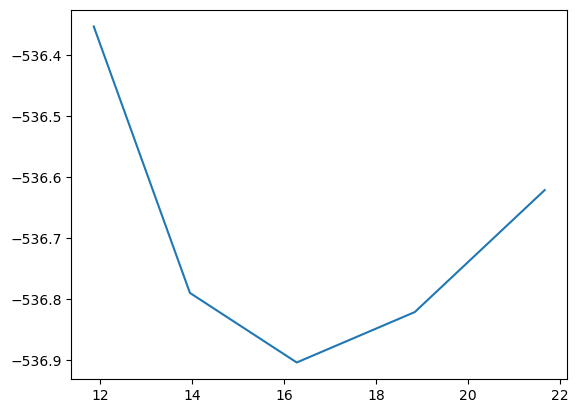

In [27]:
plt.plot(
    [v[0] for v in eos.values()],
    [v[1] for v in eos.values()],
)

## Restarting the work chain

In [28]:
restart_builder = node.get_builder_restart()

In [29]:
engine.run(restart_builder)

01/11/2024 03:10:16 PM <26503> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [168|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: 6c7d79a8-378c-4873-9667-b5d85fcc49ec (pk: 177) (aiida.calculations:qe.pw)>, 'structure_1': <CalcJobNode: uuid: b9f2c716-5e98-46a9-83a4-2d3901c195cb (pk: 180) (aiida.calculations:qe.pw)>, 'structure_2': <CalcJobNode: uuid: d3998683-844d-43e7-a066-e6134169f79e (pk: 183) (aiida.calculations:qe.pw)>, 'structure_3': <CalcJobNode: uuid: 374744c9-cfe9-434c-8031-afe98bfa14de (pk: 186) (aiida.calculations:qe.pw)>, 'structure_4': <CalcJobNode: uuid: 3ad0feb8-2fed-4de7-ae4d-e4edf6bd3b85 (pk: 189) (aiida.calculations:qe.pw)>})


{'eos_dict': <Dict: uuid: 9a157ada-e006-46ef-9872-2fed6c95aded (pk: 211)>}

## Submitting to the daemon

> Note: this requires that the daemon knows where to find the work chain, which means the work chain is stored in a module that is in the `PYTHONPATH`, or (preferably) it is developed in an installed package.

In [36]:
from aiida import engine
from eos_wc import EquationOfState

builder = EquationOfState.get_builder()

builder.structure = relaxed_structure
builder.scale_factors = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])
builder.code = orm.load_code('qe-7.2-pw@localhost')

In [37]:
engine.submit(builder)

<WorkChainNode: uuid: 372a7749-746f-4cf8-b8a4-6e0b33bf71ff (pk: 4553) (eos_wc.EquationOfState)>

The `WorkChain` approach is not very suitable for interactively building a workflow. We've been working on a more flexible variant: the `WorkTree` (I know, we like workflows so much we can't get enough of them):

https://aiida-worktree.readthedocs.io/en/stable/